## Doubly Robust Methods
### AIPW

#### Background

Augmented Inverse Propensity Weighting (AIPW) is a modification of standard Inverse Propensity Weighting to achieve double robustness. We first consider basic IPW, which considers a sample weight, or propensity score $\hat \pi (X_i)$, in the model.

$$\widehat{ATE}_{IPW} = \frac{1}{N} \sum_{i=1}^N \left[\frac{D_iY_i}{\hat \pi (X_i)} - \frac{(1-D_i)Y_i}{1-\hat \pi (X_i)}\right]$$

The augmenteed IPW, AIPW, as presetned by Glynn and Quinn, 2009 includes the outcome model in such a way that ensures doubly-robust estimation. This equations below reqrites the AIPW formulation such the basic IPW is seen clearly first along with the ourcome model augmentation. 

$$\widehat{ATE}_{AIPW} = \frac{1}{N} \sum_{i=1}^N \left(\left[\frac{D_iY_i}{\hat \pi (X_i)} - \frac{(1-D_i)Y_i}{1-\hat \pi (X_i)}\right]-\frac{(X_i - \hat \pi (X_i))Y_i }{\pi (X_i)(1-\pi (X_i))} \right) [(1-\hat \pi (X_i))\hat{\mathbb{E}}(Y_i|D_i=1,X_i) + + \hat{\pi} (X_i) \hat{\mathbb{E}}(Y_i|D_i=0,X_i)]$$

In [9]:
# Hide Cell

import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression, LinearRegression

#### Dataset

We will use a simulated dataset based on The National Study of Learning Mindsets. This was a randomized study conducted in U.S. public high schools, the purpose of which was to evaluate the impact of a nudge-like, optional intervention designed to instill students with a growth mindset. The study includes measured outcomes via an achievement score, a binary treatment of a growth mindset educational intervention, and 11 other potential confounding factors that could be parents of both the treatment and outcome. The first 5 rows of the dataset are shows in the table below. 

In [2]:
df_mindset = pd.read_csv('learning_mindset.csv')
# print(df_mindset.info())
df_mindset.head()


,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277,6,4,2,1,4,0.335,0.649,-1.311,0.224,-0.427
1,76,1,-0.450,4,12,2,1,4,0.335,0.649,-1.311,0.224,-0.427
2,76,1,0.770,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
3,76,1,-0.122,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
4,76,1,1.526,6,4,1,0,4,0.335,0.649,-1.311,0.224,-0.427


In [3]:
## Hide cell for book
# Convert categorical values to binary indicators (one-hot)
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

df_categ = pd.concat([
    df_mindset.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(df_mindset[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

# df_categ.head()

T = 'intervention'
Y = 'achievement_score'
X = df_categ.columns.drop([T, Y])

#### Understanding the data and potential bias

We begin by visualizing the achievement scores of treated and untreated cohorts with no control or consideration for the other variables. It is clear form the plot below there is an impact of the treatment as the average of the treated group's achievement scores is clearly higher. But we can intuit a positive bias in this measurement. We should note again the intervention was an option to take a growth mindset course. So although the option was offered in a random fashion, *it is highly likely students who opt-in to the treatment are likely to have the features to provide higher achievement scores regardless*. Thus, we might hypothesize controlling for this bias would decrease the ATE from the *naive ATE* (meaning no adjustment or simple difference of means of the treated and untreated groups).

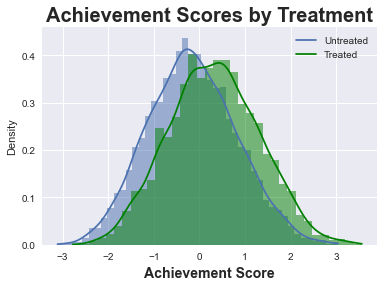

In [7]:
sns.histplot(df_mindset['achievement_score'][df_categ['intervention'] == 0], kde=True, stat="density", linewidth=0)
sns.histplot(df_mindset['achievement_score'][df_categ['intervention'] == 1], kde=True, stat="density", linewidth=0,color='g')
plt.title("Achievement Scores by Treatment", fontsize=20, fontweight = 'bold')
plt.xlabel('Achievement Score', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['Untreated', 'Treated']);


#### Method Implementations

The following code block implements the naive ATE, the standard IPW, and finally the AIPW methods as python functions. Note that propensity score, or the exposure model, is constructed as a *Logistic Regression problem*, and the outcome model is generated as a *Linear Regression problem*.

We do this to allow us to readily run many iterations of each method. We will use a bootstrap subsample method, where we will sample 1% of the original data (~100 data points), 100 times. This will allow us to generate a distribution of ATEs with an empirical standard deviation. Thus we can report our results comparing each of the three methods using various exposure and outcome models with 95% confidence intervals as well.

In [7]:
#### Define Estimation methods ####

### Linear Regression T on Y
def naive_ATE(df, T, Y):
    return df[Y][df_categ[T] == 1].mean() - df_categ[Y][df_categ[T] == 0].mean()

### IPW
def IPW(df, X, T, Y,true_ps = True):

    if true_ps:
        p_scores = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    else:
        p_scores = np.random.uniform(0.1, 0.9, df.shape[0])

    df_ps = df.assign(propensity_score=p_scores)

    weight = ((df_ps["intervention"]-df_ps["propensity_score"]) / (df_ps["propensity_score"]*(1-df_ps["propensity_score"])))

    weight_t = 1/df_ps.query("intervention==1")["propensity_score"]
    weight_nt = 1/(1-df_ps.query("intervention==0")["propensity_score"])

    y1 = sum(df_ps.query("intervention==1")["achievement_score"]*weight) / len(df_ps)
    y0 = sum(df_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(df_ps)

    return np.mean(weight * df_ps["achievement_score"]), p_scores, df_ps

### AIPW
def AIPW(df, X, T, Y,true_ps = True,true_mus = True):
    if true_ps:
        p_scores = LogisticRegression(C=1e6,max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    else:
        p_scores = np.random.uniform(0.1, 0.9, df.shape[0])

    if true_mus:
        mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    else:
        mu0 = np.random.uniform(0, 1, df.shape[0])
        mu1 = np.random.uniform(0, 1, df.shape[0])

    return (
        np.mean(df[T]*(df[Y] - mu1)/p_scores + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-p_scores) + mu0)
    ), p_scores, mu0, mu1

#### Experiments and Results

The following code block shows our bootstrap sampling method and results display. In this initial experiment, we correctly specify both the exposure and outcome models. The results are displayed in the plot and table below.

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


,Mean ATE,Std Dev,[.025,.975]
AIPW,0.390,0.017,0.358,0.427
IPW,0.390,0.017,0.359,0.426
Naive,0.473,0.016,0.446,0.503


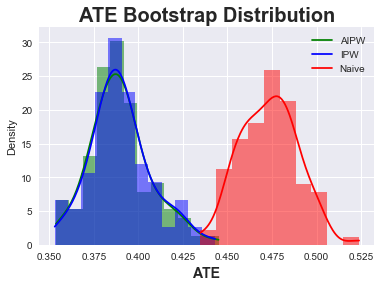

In [11]:
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in range(bootstrap_sample):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.histplot(AIPW_ates,kde=True, stat="density", linewidth=0,color='g')
sns.histplot(IPW_ates, kde=True, stat="density", linewidth=0,color='b')
sns.histplot(naives_ates,kde=True, stat="density", linewidth=0, color='r')
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T


From the results it is clear both IPW and AIPW account for a positive bias we hypothesized. They estimate the ATE at ~$0.39$, up from the naive ATE estimate of ~$0.47$. We also note the IPW and AIPW methods agree with very close estimates and with very similar 95% confidence intervals. This is unsurprising considering the exposure model is correctly specified using logistic regression for both methods.

Now that we have propensity scores, we can also perform a quick positivity check visualizing the distribution of our propensity scores to ensure we meet the positivity/overlap assumption which the plot below demonstrates.

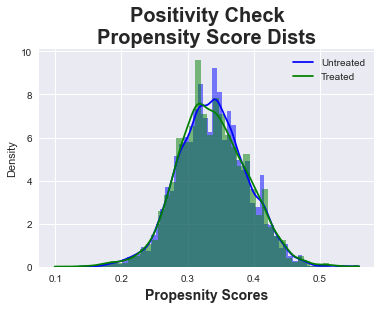

In [12]:
# Hide Cell
sns.histplot(ps[df_categ['intervention']==0], kde=True, stat="density", linewidth=0,color='b')
sns.histplot(ps[df_categ['intervention']==1], kde=True, stat="density", linewidth=0,color='g')
plt.title("Positivity Check\nPropensity Score Dists", fontsize=20, fontweight = 'bold')
plt.xlabel('Propesnity Scores', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['Untreated', 'Treated']);

In the second experiment, we specify a bad exposure model. Instead of using logistic regression, we simply sample a uniform random distribution: $$ \hat \pi (X_i) \sim U(0.1,0.9) $$
As we can see from the results below, the AIPE method is effectively stable, estimating a slightly lower ATE of about ~$0.38$. The standard deviation also increases slightly. On the other hand, the IPW method does far worse than the naive method, which again makes sense as we are feeding it random noise for the propensity scores. This is the first example of a doubly robust method showing how, since the outcome model is correctly specified, the estimation is still robust even to random noise for the exposure model.


100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


,Mean ATE,Std Dev,[.025,.975]
AIPW,0.386,0.025,0.342,0.427
IPW,0.566,0.036,0.506,0.637
Naive,0.472,0.018,0.439,0.507


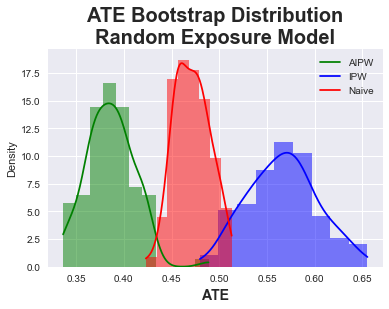

In [13]:
# Hide cell
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in range(bootstrap_sample):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_ps=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y,true_ps=False)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.histplot(AIPW_ates, kde=True, stat="density", linewidth=0,color='g')
sns.histplot(IPW_ates, kde=True, stat="density", linewidth=0,color='b')
sns.histplot(naives_ates, kde=True, stat="density", linewidth=0,color='r')
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Exposure Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T

In the third experiment, we now investigate the impact of a bad outcome model. We again sample from a uniform distribution to obtain the incorrect outcome data: $$\mu_d(X_i) \sim U(0,1) $$
 
Here once again see the AIPW and IPW methods both agree and estimate ~$0.39$. AIPW again shows the doubly robust property against the completely random outcome model, while IPW is unimpacted since the exposure model is correct. Both hence perform similarly to the original experiment.

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


,Mean ATE,Std Dev,[.025,.975]
AIPW,0.390,0.018,0.361,0.426
IPW,0.391,0.017,0.362,0.424
Naive,0.474,0.016,0.441,0.502


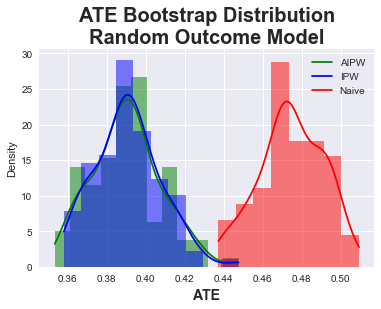

In [14]:
# Hide cell
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_mus=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.histplot(AIPW_ates, kde=True, stat="density", linewidth=0,color='g')
sns.histplot(IPW_ates, kde=True, stat="density", linewidth=0,color='b')
sns.histplot(naives_ates, kde=True, stat="density", linewidth=0,color='r')
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Outcome Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T

In the final experiment, we show the impact of a bad outcome and exposure model: $$\mu_d(X_i) \sim U(0,1),  \hat \pi (X_i) \sim U(0.1,0.9) $$
 
In this experiment, we see that AIPW performs very poorly, vastly over-estimating the ATE. In this instance, either naive or IPW would perform better, although the naive without any consideration for random models does best. 

100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


,Mean ATE,Std Dev,[.025,.975]
AIPW,1.047,0.034,0.990,1.115
IPW,0.568,0.033,0.512,0.626
Naive,0.472,0.016,0.444,0.501


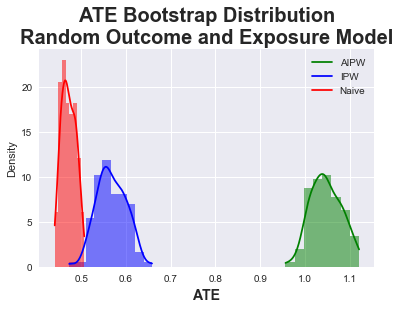

In [15]:
# Hide cell
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_mus=False,true_ps=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y,true_ps=False)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.histplot(AIPW_ates, kde=True, stat="density", linewidth=0,color='g')
sns.histplot(IPW_ates, kde=True, stat="density", linewidth=0,color='b')
sns.histplot(naives_ates, kde=True, stat="density", linewidth=0,color='r')
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Outcome and Exposure Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T

#### Concluding Thoughts for AIPE

We clearly demonstrate AIPW's doubly robust properties using the simulated National Mindset dataset. But it is important to note, our 'incorrect' models were uniform random which would be about as poor as one could imagine. In reality, misspecified models contain more subtle biases or noise, and thus there is a whole host of literature investigating the sensitivity of doubly robust methods to various types and degrees of misspecification. For instance in the example where both models were incorrect, one could imagine scenarios where model misspecifications cancel out, and actually produce a relatively accurate ATE estimate. It is an area of active research on when doubly robust methods should be used when there might be uncertainty on both models.

### TMLE

#### Background and Setup
Targeted Maximum Likelihood Estimation (TMLE) is a semi-parametric method with minimal assumptions on the underlying data distribution demonstrated by Van der Laan & Rubin in 2006. We will briefly walk through the steps of a TMLE estimation algorithm on the same data without diving too deep into the formulation.

In [1]:
# Hide Cell
import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm
from scipy.special import logit, expit
import statsmodels.api as sm

# Super Learner Import
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

The TMLE algorithm begins by first estimating a model by training and predicting a super learning ensemble of algorithms. In the hidden code block below, we do so using 9 models from pre-built libraries. We report the root mean squared errors for all algorithms, demonstrating the super learner ensemble performs best. 

In [4]:
# Hide Cell
# create a list of base-models
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(ElasticNet())
	models.append(SVR(gamma='scale'))
	models.append(DecisionTreeRegressor())
	models.append(KNeighborsRegressor())
	models.append(AdaBoostRegressor())
	models.append(BaggingRegressor(n_estimators=10))
	models.append(RandomForestRegressor(n_estimators=10))
	models.append(ExtraTreesRegressor(n_estimators=10))
	return models
 
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)
 
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model
 
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
 
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)
 
# create the inputs and outputs
X = df_categ[df_categ.columns.drop([Y])].to_numpy()
y = df_categ[Y].to_numpy()
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Train (5195, 31) (5195,) Test (5196, 31) (5196,)
Meta  (5195, 9) (5195,)
LinearRegression: RMSE 0.832
ElasticNet: RMSE 0.986
SVR: RMSE 0.847
DecisionTreeRegressor: RMSE 1.020
KNeighborsRegressor: RMSE 0.885
AdaBoostRegressor: RMSE 0.825
BaggingRegressor: RMSE 0.900
RandomForestRegressor: RMSE 0.900
ExtraTreesRegressor: RMSE 0.948
Super Learner: RMSE 0.810


In the second step we use the super learner algorithm to estimate the expected value of the outcome using the treatment and confounders as predictors. Within this, there are three steps:
1. predict with the interventions
2. predict with every sample receiving no treatment
3. predict with every sample receiving treatment.
 
We can take the difference of the last two as an ATE estimate, which is effectively the g-estimation approach. We see below this provides a decent 1st estimate. 

In [5]:
df_predict = df_categ.copy()
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_a = super_learner_predictions(X, models, meta_model)
df_predict['intervention'] = 0
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_0 = super_learner_predictions(X, models, meta_model)
df_predict['intervention'] = 1
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_1 = super_learner_predictions(X, models, meta_model)

df_tmle = pd.DataFrame([df_categ[Y].to_numpy(),df_categ[T].to_numpy(), Q_a,Q_0,Q_1]).T
df_tmle.columns = ['Y','D','Q_a','Q_0','Q_1']

df_tmle['Q_1'].mean() - df_tmle['Q_0'].mean()

0.40127574734587146

In the third step we obtain propensity scores (ps) and form a "clever covariate" from these values which will be used to refine our model. the inverse ps with indicator is added with the negative inverse of not being treated (1-ps) also multiplied with indicator if not being treated:

$$H(D,X) = \frac{I(D=1)}{\hat \pi (X_i)} - \frac{I(D=0)}{1 - \hat \pi (X_i)}

In [17]:
T = 'intervention'
Y = 'achievement_score'
X = df_categ.columns.drop([T, Y])
ate, ps,_ = IPW(df_categ, X, T, Y)

df_tmle['H_1'] = 1/ps
df_tmle['H_0'] = -1/(1-ps)
df_tmle['H_a'] = df_tmle['D'] * df_tmle['H_1'] + (1-df_tmle['D']) * df_tmle['H_0']

In the fourth and fifth steps, we estimate the fluctuation parameter using the logit function:
 
$$logit(\mathbb{E}[Y|D,X]) = logit(\hat{\mathbb{E}}[Y|D,X]) = \epsilon H(D,X)$$
 
We then update out initial estimates with the fluctuation parameter adjustment.


In [30]:
eps_fit = np.polyfit(df_tmle['H_a'], df_tmle['Y'] - df_tmle['Q_a'], 1)[0]
df_tmle['Q_0_hat'] = df_tmle['Q_0'] + eps_fit * df_tmle['H_0']
df_tmle['Q_1_hat'] = df_tmle['Q_1'] + eps_fit * df_tmle['H_1']
df_tmle['Q_a_hat'] = df_tmle['Q_a'] + eps_fit * df_tmle['H_a']

In [32]:
TMLE_ate = df_tmle['Q_1_hat'].mean() - df_tmle['Q_0_hat'].mean()
print('TMLE TAE estimate: {:.4f}'.format(TMLE_ate))

TMLE TAE estimate: 0.3798


We see how the fluctuation adjusted outcomes estimates vastly improves the ATE to be more in line with AIPW. One major benefit of TMLE is a whole set of nice statistical and convergence properties. In this case, we can use something called the influence function to calculate a closed form standard error, unlike the empirical error estimates we gained by bootstrapping in the AIPW case.
 
$$\hat{IF} = (Y-\hat{\mathbb{E}}*[Y|D,X])H(D,X) + \hat{\mathbb{E}}*[Y|D=1,X] - \hat{\mathbb{E}}*[Y|D=0,X] - ATE_{TMLE}$$
$$SE = \sqrt{var(IF)/N}$$
 
Using the above method, we see we get a SE very similar to our AIPW empirical methods.

In [34]:
IF = (df_tmle['Y'] - df_tmle['Q_a_hat']) * df_tmle['H_a'] + df_tmle['Q_1_hat'] - df_tmle['Q_0_hat'] - TMLE_ate
print('SE calculated from influcence function: {:.4f}'.format(np.sqrt(IF.var()/df_tmle.shape[0])))

SE calculated from influcence function: 0.0165


### References  
    
    1. Glynn, A. N., & Quinn, K. M. (2010). An introduction to the augmented inverse propensity weighted estimator. Political analysis, 18(1), 36-56.

    2. https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html

    3. Gruber S, van der Laan MJ. Targeted minimum loss based estimator that outperforms a given estimator. Int J Biostat. 2012 May 18;8(1):Article 11. doi: 10.1515/1557-4679.1332. PMID: 22628356; PMCID: PMC6052865.
